In [1]:

from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import time


In [2]:

cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit="2GB")
client = Client(cluster)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46875,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45011,Total threads: 1
Dashboard: http://127.0.0.1:43245/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:43343,


In [3]:

df = dd.read_csv("EDA_Student_Depression_Dataset.csv")
df.head()


,Gender,Age,Academic_Pressure,CGPA,Study_Satisfaction,Sleep_Duration,Have_you_ever_had_suicidal_thoughts?,Work/Study_Hours,Financial_Stress,Family_History_of_Mental_Illness,Depression,Is_Metropolis,Dietary_Habits_Healthy,Dietary_Habits_Moderate,Dietary_Habits_Unhealthy,Degree_bachelor,Degree_high_school,Degree_masters_phd
0,1,33.0,5.0,8.97,2.0,0,1,3.0,1.0,0,1,0,1,0,0,1,0,0
1,0,24.0,2.0,5.90,5.0,0,0,3.0,2.0,1,0,1,0,1,0,1,0,0
2,1,31.0,3.0,7.03,5.0,0,0,9.0,1.0,1,0,0,1,0,0,1,0,0
3,0,28.0,3.0,5.59,2.0,1,1,4.0,5.0,1,1,0,0,1,0,1,0,0
4,0,25.0,4.0,8.13,3.0,0,1,1.0,1.0,0,0,1,0,1,0,0,0,1


In [4]:

columns = df.columns.tolist()
columns.remove('Depression')

X = df[columns]
y = df['Depression']


In [5]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train_np = X_train.compute()
X_test_np = X_test.compute()
y_train_np = y_train.compute()
y_test_np = y_test.compute()


/home/emanuele_fossi1201/jupyter_env/lib/python3.11/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [6]:

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100],
    'max_depth': [10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)

start_time_cv = time.time()
grid_search.fit(X_train_np, y_train_np)
end_time_cv = time.time()

print(f"Tempo cross-validation: {end_time_cv - start_time_cv:.2f} secondi")

best_model = grid_search.best_estimator_
y_proba_cv = best_model.predict_proba(X_test_np)[:, 1]
auc_cv = roc_auc_score(y_test_np, y_proba_cv)
print(f"AUC (Cross-Validated): {auc_cv}")


Tempo cross-validation: 8.86 secondi
AUC (Cross-Validated): 0.9209195085765035


In [7]:

rf = RandomForestClassifier(n_estimators=200, max_depth=10)

start_time = time.time()
model = rf.fit(X_train_np, y_train_np)
end_time = time.time()

training_time = end_time - start_time
print(f"Tempo di addestramento: {training_time:.2f} secondi")

y_pred = model.predict(X_test_np)


Tempo di addestramento: 3.86 secondi


AUC: 0.9209087685841454

Accuracy score on the test set: 0.841970802919708

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      2245
           1       0.85      0.89      0.87      3235

    accuracy                           0.84      5480
   macro avg       0.84      0.83      0.84      5480
weighted avg       0.84      0.84      0.84      5480



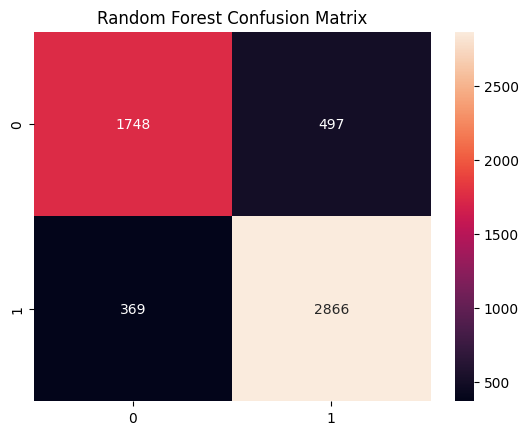

In [8]:

print("AUC:", roc_auc_score(y_test_np, model.predict_proba(X_test_np)[:, 1]))

print(f"\nAccuracy score on the test set: {accuracy_score(y_test_np, y_pred)}")
print(f"\nClassification Report:\n{classification_report(y_test_np, y_pred)}")

cm = confusion_matrix(y_test_np, y_pred)
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_title('Random Forest Confusion Matrix')
plt.show()
